In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV 

from nltk import wordpunct_tokenize as wt
from nltk import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import string
import re
import json

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfTransformer

import pylab
import matplotlib.pyplot as plt

In [2]:
 from sklearn.metrics import precision_recall_fscore_support

In [325]:
# the classification method that i'll be using.
# from sklearn.naive_bayes import MultinomialNB

In [3]:
#jeopardy questions dataset's file path
jq_json_path = "../JEOPARDY_QUESTIONS.json"
with open(jq_json_path) as f:
    data = json.load(f)
f.close()
#jeopardy dataset
jd = pd.DataFrame(data)

In [4]:
def convert_value_to_int(x, translator):
    if (x==None):
        return x
    return int(x.translate(translator))

def tokenize(sent, translator):
    #lower the terms.
    return sent.lower().translate(translator)

def preprocessing(df, punctuation=True, lower=True, stopwords=True):
    #preprocess punctuations from categories, questions and answers.
    lemmatizer = WordNetLemmatizer()
    translator = str.maketrans('', '', string.punctuation)
    df['question'] = df['question'].apply(lambda x: tokenize(x, translator))
    df['answer'] = df['answer'].apply(lambda x: tokenize(x, translator))
    #convert the values to actual integers
    df['value'] = df['value'].apply(lambda x: convert_value_to_int(x, translator))
    
#     preprocess air date
    df['air_date'] = df['air_date'].apply(lambda x: int(x.split('-')[0]))

In [5]:
def select_top_n_categories(df, n):
    topic_list = df.groupby('category').size().sort_values(ascending=False)[:n].index.tolist()
    df = df[df['category'].isin(topic_list)]
    return df

In [6]:
def make_corpus(questions):
    #make list of questions
    return ' '.join(questions.tolist())
    

In [7]:
#preprocessing question values and 'value' parameters to change it to 0.
preprocessing(jd)

In [8]:
#get top 10 categories. Questions from this are going to be the basis for our dataset.
jd_10 = select_top_n_categories(jd, 10)
#This makes corpus which will be used by the x_train vectors.
sent_corpus = jd_10['question'].tolist()

#corpus where answers are concatenated before
sent_corpus_answers = jd_10['answer'] + ' ' + jd_10['question']

#corpus where questions are concatenated before
sent_corpus_questions = jd_10['question'] + ' ' + jd_10['answer']

#trial for final
final_corpus = jd_10['answer'] + ' ' + jd_10['question'] + ' ' + jd_10['answer']

#label encoder which will be used to convert categories into numerical class values. e.g, ['egg', 'ham', 'egg'] -> [0, 1, 0]
lb = LabelEncoder()

In [9]:
def make_predictions(clf, x_tr, y_tr, x_te):
    clf.fit(x_tr, y_tr)
    pred = clf.predict(x_te)
    

In [10]:
def countvectorizing(stopwords=True, min_df=1, ng=(1, 1)):
    if(stopwords):
        count_vect = CountVectorizer(ngram_range=ng, stop_words="english", min_df=min_df)
    else:
        count_vect = CountVectorizer(ngram_range=ng, min_df=min_df)
    return count_vect

#1-gram
#finds the optimal parameters
def find_optimal_params(clf, corpus, params=None):
    #the list of ngrams tested
    ng_list = [(1,1), (1,2), (2,2)]
    #to include stopwords or not:
    stopword_list = [True, False]
    
    #best clf from grid search and its accuracy score, currently stored with dummy values.
    best_clf = 0
    best_score = [0, 0, 0, 0]
    conf_matrix = []
    
    #best settings for countvectorizer which are initialized with dummy values
    stopw = False
    ng_val = (1,1)
    results = []
    for ngram in ng_list:
        for stopword in stopword_list:
            count_vect = countvectorizing(ng=ngram, stopwords=stopword)
            x_value = count_vect.fit_transform(corpus)
            y_value = lb.fit_transform(jd_10['category'].tolist())

            X_train, X_test, y_train, y_test = train_test_split(x_value, y_value, test_size=0.2, random_state=33)
            
            #predictions, clf = make_predictions(clf, X_train, y_train, X_test)
            # settings to test with tfidf_transformer: Performance was surprisingly bad with tf_idf so it is ommitted.
            # tfidf_transformer = TfidfTransformer()
            # x_tf_train = tfidf_transformer.fit_transform(x_value)
            
            #runs grid search on the passed classifier with its range of parameters
            if (params!=None):
                clf_grid = GridSearchCV(clf, params, cv=5)
            else:
                #just reset it as the baseline model.
                clf_grid = clf
            clf_grid.fit(X_train, y_train)
            pred = clf_grid.predict(X_test)
            
            score = precision_recall_fscore_support(y_test, pred, average='weighted')
            #score = clf_grid.score(X_test, y_test)
            results.append((score, ngram, stopword))
            #store the best classifier, its score, stopword setting and ngram values.
            if (score[2]> best_score[2]):
                best_score = score
                best_clf = clf_grid
                stopw = stopword
                conf_matrix = confusion_matrix(y_test, pred)
                ng_val = ngram
    
    #return the optimal classifiers and its attributes
    return best_clf, [best_score, stopw, ng_val, conf_matrix], results

In [450]:
# splitting train test split
# X_train, X_test, y_train, y_test = train_test_split(x_value, y_value, test_size=0.2, random_state=33)

In [12]:
baseline = DummyClassifier()
print('Running Dummy Classifier: ')
clf_base, baseline_attributes, baseline_results = find_optimal_params(baseline, sent_corpus_answers)

print('Printing it\'s F1-score\n')
print(baseline_attributes[0][2])
#get the accuracy of random baseline
# confMatrix = confusion_matrix(baselineP, y_test)
# accuracy = baseline.score(X_test, y_test)

Running Dummy Classifier: 
Printing it's F1-score

0.106017001388


In [14]:
#alpha is the laplace bias
parameters = {'alpha':np.arange(0.1, 2, 0.1)}
print('Running Multinomial Naive Bayes. Testing for optimal paramater for alpha range of 0.1 to 2')
mlb = MultinomialNB()
# clf = GridSearchCV(mlb, parameters, cv=5)
# clf.best_estimator_
clf, attributes, mlb_results = find_optimal_params(mlb, sent_corpus_answers, parameters)
print('Best variant of the estimator is: ' + str(clf.best_estimator_))
print('With ngrams setting set to: ' + str(attributes[2]))
if (attributes[1]):
    print('With removal of stopwords')
else:
    print('With no removal of stopwords')
print('F1-Score: '+str(attributes[0][2]) +'\n')

#potential logistic regression and linear svm models to test on
# log = linear_model.LogisticRegression(C=3)

# lsvm = svm.SVC(C=1, kernel='linear')

Running Multinomial Naive Bayes. Testing for optimal paramater for alpha range of 0.1 to 2
Best variant of the estimator is: MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)
With ngrams setting set to: (1, 2)
With no removal of stopwords
F1-Score: 0.66218974419



In [837]:
# attributes

[(0.67229061733193318, 0.67784431137724555, 0.65973000450787711, None),
 False,
 (1, 2),
 array([[63,  0,  2,  3,  1,  3,  4,  1,  0,  2],
        [10, 58,  1,  3,  7,  3,  4,  6,  1,  3],
        [ 3,  0, 68,  0,  0,  0,  0,  0,  0,  0],
        [13,  0,  0, 18,  2,  0,  4,  0,  0, 29],
        [ 1,  3,  0,  1, 92,  1,  3,  0,  1,  2],
        [ 7,  1,  4,  2, 11, 15, 22,  4, 11,  8],
        [ 5,  0,  0,  1,  4,  6, 83,  0,  6,  0],
        [ 1,  0,  1,  2,  0,  5,  3, 53,  3,  2],
        [ 1,  0,  0,  0,  2,  1,  1,  1, 79,  0],
        [13,  0,  0, 15,  2,  1,  6,  0,  0, 37]], dtype=int64)]

In [714]:
topic_list = lb.inverse_transform(list(range(0,10)))

In [684]:
# in quesstion
# jd_10['air_date'] = jd_10['air_date'].apply(lambda x: int(x.split('-')[0]))

In [715]:
def filter_air_dates(df, topic_list):
    
    #calculate the total_index
    total_index = df.groupby('air_date').size().index
    
    length = len(total_index)
    topic_counts = []
    for i in range(len(topic_list)):
        df_series = df[df['category']==topic_list[i]].groupby('air_date').size()
        df_index = df_series.index
        
        starterm = 0
        endterm = 0
        count = []
        for i in range(int(length/5)+1):
            starterm = 1*endterm
            endterm = starterm+5
            valid_indexes = []
            if endterm < length:
                valid_indexes = [x for x in df_index if x <= total_index[endterm-1] and x >= total_index[starterm]]
            else:
                valid_indexes = [x for x in df_index if x <= total_index[-1] and x >= total_index[starterm]]
            
            count.append(sum(df_series[valid_indexes]))
        topic_counts.append(count)
    plotting_indexes = [str(total_index[i-5])+'-'+str(total_index[i-1]) for i in range(5, len(total_index), 5)]
    plotting_indexes.append((str(total_index[25])+'-'+str(total_index[-1])))
    return topic_counts, plotting_indexes
            
        

In [673]:
topic_counts, plotting_index = filter_air_dates(jd_10, topic_list)

In [676]:
def plot_range_of_years_graph(topic_counts, label, plotting_index, x_axis=list(range(1,7)), size=(8,6)):
    x_axis = list(range(1, 7))
    for i in range(len(topic_counts)):
        pylab.plot(x_axis, topic_counts[i], 'o')
    pylab.legend(label)
    pylab.title('Variation in Number Of Questions Vs Range of Years by Category')
    pylab.xlabel('Range Of Years')
    pylab.ylabel('Number Of Questions')
    pylab.xticks(x_axis, plotting_index)
    pylab.figure(figsize=size)
    pylab.show()

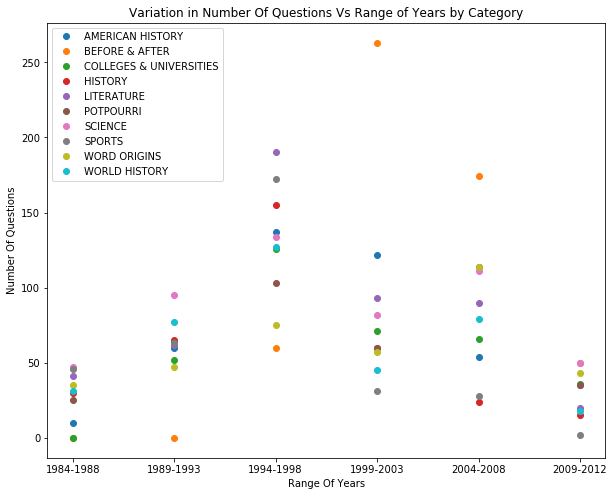

In [683]:
pylab.figure(figsize=(10,8))
plot_range_of_years_graph(topic_counts, topic_list, plotting_index, size=(12,10))

In [725]:
def calculate_average_words(df):
    df['word_count'] = df['question'].apply(lambda x: len(wt(x)))
    results = df.groupby('category')['word_count'].sum()/df.groupby('category').size()
    return results

In [726]:
average_word_count = calculate_average_words(jd_10)

C:\Users\abhi1\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [732]:
print('Average Word Count\n')
print(average_word_count)

Average Word Count

category
AMERICAN HISTORY           15.956938
BEFORE & AFTER             12.546618
COLLEGES & UNIVERSITIES    14.615385
HISTORY                    15.083095
LITERATURE                 14.812500
POTPOURRI                  15.259352
SCIENCE                    15.533719
SPORTS                     15.421053
WORD ORIGINS               15.867925
WORLD HISTORY              15.442971
dtype: float64


In [754]:
# final_sample = jd_10[['question', 'category']]

# final_sample['in or not'] = [1 if 'my' in words else 0 for words in final_sample['question'].apply(lambda x: x.split(' '))]

# final_sample.groupby('category')['in or not'].sum()

In [ ]:
#possible investigations for the classes, is to see which ones are the most frequent depending on time periods

#Average Number of words per category (Number of words/Number of rows)
#Why was the answer feature not used? Hard to model it with a two gram model, 